# Credit Card Fraud Detection 

In [1]:
%pylab inline
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD, RMSprop
from keras.regularizers import l2
from keras.backend.tensorflow_backend import set_session
from keras.utils import np_utils
import keras

import tensorflow as tf
import pandas as pd
import numpy as np


from IPython.display import SVG, Image
from keras.utils.visualize_util import model_to_dot

np.random.seed(0)

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data

[Credit Card Fraud Detection - Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud)에서 다운받을수 있습니다.

데이터는 2013년 유럽 카드회사의 이틀동안 일어난 transactions에 관한 것이며, <br>
492건의 frauds 가 284,807건의 transactions중에 일어 났습니다.

Class에서 1은 fraud를 뜻하며, 0은 아닌것을 말합니다.

Time데이터는 첫번재 Column으로부터 몇초 이후에 발생한 transaction이라는 뜻입니다. <br>
나머지 데이터들은 PCA의 규제에 의해서 어떤 데이터인지 밝히지 않습니다.

In [2]:
data = pd.read_csv('/dataset/time-series/credit-card-fraud-detection/creditcard.csv')

# Preprocessing Amount
amt_scale = StandardScaler()
data['NormAmount'] =  amt_scale.fit_transform(data['Amount'])

# Split Train and Test Data
X = data.drop(['Time', 'Amount', 'Class'], axis=1).as_matrix()
Y = data['Class'].as_matrix()

# Standardization
scale_x = StandardScaler()
X = scale_x.fit_transform(X)

train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.25, random_state=1)

fraud_test_y = test_y == 1
fraud_test_x = test_x[fraud_test_y]
fraud_test_y = test_y[fraud_test_y]

train_category_y = np_utils.to_categorical(train_y)
test_category_y = np_utils.to_categorical(test_y)

/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


#### Checking the number of fraud transactions in training and test data

In [3]:
print('The number of Fraud transactions in Training Data:', train_y[train_y == 1].shape[0])
print('The number of Fraud transactions in Test Data:',  test_y[test_y == 1].shape[0])

The number of Fraud transactions in Training Data: 381
The number of Fraud transactions in Test Data: 111


#### Checking the target classes

fraud transactions이 492개밖에 되지 않기 때문에, 일반적인 classification algorithm으로 돌리면 물론 정확도는 매우 높게 나오지만.. 
실상은 1에 해당하는 fraud transactions에서는 대부분 틀릴 가능성이 매우 높습니다. 


In [3]:
pd.value_counts(data['Class'], sort=True)

0    284315
1       492
Name: Class, dtype: int64

## Resampling

resampling에는 여러가지 방법이 있습니다. 

1. Over Sampling: SMOTE (Synthetic Minority Over-Sampling Technique)
2. Under Sampling

아래의 resample function에서는 5:5의 비율로 under sampling을 해줍니다.<br>
resample을 하면서 시간관계가 어차피 깨지기 때문에 (사실 각각의 transactions들 사이에 상관관계가 있는지도 모르겠음)<br>
shuffle을 통해서 train되는 데이터를 augment해줍니다.

In [4]:
def resample(X, Y):
    index = np.arange(Y.shape[0])
    fraud_indices = index[Y == 1]
    normal_indices = index[Y == 0]
    random_normal_indices = np.random.choice(normal_indices, len(fraud_indices))
    
    sample_indices = np.concatenate([fraud_indices, random_normal_indices])
    np.random.shuffle(sample_indices)
    sample_indices = np.array(sample_indices)
    
    sample_x = X[sample_indices]
    sample_y = Y[sample_indices]
    return sample_x, sample_y

# Logistic Regression

전체적으로 0.99% accuracy를 보이지만, 실제 fraud data만 test를 했을때는 0.57%로.. 실질적으로 못맞추는 수준입니다.<br>
사실 일반적인 알고리즘으로 학습시키기 위해서는 over sampling (SMOTE 같은) 또는 under sampling이 필요합니다.<br>
sampling을 통해서 skewed data를 보정하는 것입니다.

#### resample 없이 데이터 학습뒤 예측하면..

In [6]:
lg = LogisticRegression()
lg.fit(train_x, train_y)
predicted_y = lg.predict(test_x)
accuracy_score(test_y, predicted_y)

0.99914328249206485

In [7]:
predicted_y = lg.predict(fraud_test_x)
accuracy_score(fraud_test_y, predicted_y)

0.57657657657657657

#### resampled data로 학습뒤 예측하면...
0.88 ~ 0.92 까지 예측률이 높아지게 됩니다.

In [8]:
lg = LogisticRegression()
lg.fit(*resample(train_x, train_y))

predicted_y = lg.predict(test_x)
accuracy_score(test_y, predicted_y)

0.96657397264121792

In [9]:
predicted_y = lg.predict(fraud_test_x)
accuracy_score(fraud_test_y, predicted_y)

0.89189189189189189

# Decision Tree

#### resample 없이 데이터 학습뒤 예측하면..

In [10]:
dtc = DecisionTreeClassifier(max_depth=10, criterion='entropy')
dtc.fit(train_x, train_y)
predicted_y = dtc.predict(test_x)
accuracy_score(test_y, predicted_y)

0.99932586163310022

In [11]:
predicted_y = dtc.predict(fraud_test_x)
accuracy_score(fraud_test_y, predicted_y)

0.76576576576576572

#### resampled data로 학습뒤 예측하면...

In [12]:
dtc = DecisionTreeClassifier(max_depth=10, criterion='entropy')
for i in range(3):
    dtc.fit(*resample(train_x, train_y))
    predicted_y = dtc.predict(test_x)
    print(accuracy_score(test_y, predicted_y))

0.905606584085
0.896435493385
0.915957416926


In [13]:
predicted_y = dtc.predict(fraud_test_x)
accuracy_score(fraud_test_y, predicted_y)

0.86486486486486491

# Deep Learning with Keras

하.. 드디어 딥러닝으로.. 해보면 어떤 결과가 나올 것인가.. Sampling VS UnSampling!

#### Data Preparation

In [197]:
train_y = np_utils.to_categorical(train_y)
train_y

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

#### Model

In [6]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
set_session(tf.Session(config=config))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense01 (Dense)                  (None, 1)             30          dense_input_2[0][0]              
____________________________________________________________________________________________________
activation01 (Activation)        (None, 1)             0           dense01[0][0]                    
Total params: 30
Trainable params: 30
Non-trainable params: 0
____________________________________________________________________________________________________


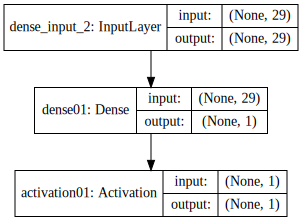

In [7]:
def generate_model():
    model = Sequential()

    model.add(Dense(output_dim=1, input_dim=29, name='dense01'))
    model.add(Activation('sigmoid', name='activation01'))
#     model.add(Dropout(0.5))
#     model.add(Dense(output_dim=256, input_dim=512, name='dense02'))
#     model.add(Activation('relu', name='activation02'))
#     model.add(Dropout(0.5))
#     model.add(Dense(output_dim=1, name='dense03'))
#     model.add(Activation('softmax', name='activation03'))

    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model


# # Visualization
model = generate_model()
model.summary()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))


#### resample 없이 데이터 학습뒤 예측하면..

In [180]:
model = generate_model()
model.fit(train_x, train_y, verbose=2)

Epoch 1/10
14s - loss: 15.9139 - acc: 0.0018
Epoch 2/10
13s - loss: 15.9139 - acc: 0.0018
Epoch 3/10
13s - loss: 15.9139 - acc: 0.0018
Epoch 4/10
14s - loss: 15.9139 - acc: 0.0018
Epoch 5/10
13s - loss: 15.9139 - acc: 0.0018
Epoch 6/10
13s - loss: 15.9139 - acc: 0.0018
Epoch 7/10
12s - loss: 15.9139 - acc: 0.0018
Epoch 8/10
12s - loss: 15.9139 - acc: 0.0018
Epoch 9/10
13s - loss: 15.9139 - acc: 0.0018
Epoch 10/10
14s - loss: 15.9139 - acc: 0.0018


In [67]:
predicted_y = model.predict(test_x)
predicted_y = predicted_y.reshape(predicted_y.shape[0])
print(accuracy_score(test_y, predicted_y))

0.00155894497346


In [66]:
predicted_y = model.predict(fraud_test_x)
predicted_y = predicted_y.reshape(predicted_y.shape[0])
accuracy_score(fraud_test_y, predicted_y)

1.0

#### resampled data로 학습뒤 예측하면...

In [9]:
model = generate_model()
model.fit(*resample(train_x, train_y), verbose=2, nb_epoch=10)

Epoch 1/10
0s - loss: 0.6870 - acc: 0.6404
Epoch 2/10
0s - loss: 0.6135 - acc: 0.6745
Epoch 3/10
0s - loss: 0.5767 - acc: 0.6903
Epoch 4/10
0s - loss: 0.5510 - acc: 0.7021
Epoch 5/10
0s - loss: 0.5304 - acc: 0.7100
Epoch 6/10
0s - loss: 0.5105 - acc: 0.7165
Epoch 7/10
0s - loss: 0.4935 - acc: 0.7231
Epoch 8/10
0s - loss: 0.4777 - acc: 0.7388
Epoch 9/10
0s - loss: 0.4633 - acc: 0.7415
Epoch 10/10
0s - loss: 0.4490 - acc: 0.7441


In [10]:
predicted_y = model.predict(test_x)
predicted_y = predicted_y.reshape(predicted_y.shape[0])
print(predicted_y)
print(cross_val_score(test_y, predicted_y))

[ 0.15493922  0.48184815  0.37785113 ...,  0.50462222  0.24449366
  0.71220315]


TypeError: estimator should be an estimator implementing 'fit' method, array([0, 0, 0, ..., 0, 0, 0]) was passed

In [18]:
predicted_y = model.predict(fraud_test_x)
predicted_y = predicted_y.reshape(predicted_y.shape[0])
accuracy_score(fraud_test_y, predicted_y)

1.0

In [146]:
w = model.weights[0]
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_94 (Dense)                 (None, 1)             30          dense_input_40[0][0]             
Total params: 30
Trainable params: 30
Non-trainable params: 0
____________________________________________________________________________________________________
